In [274]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [275]:
# set paths
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/cake/'

In [276]:
# import data
df_raw = pd.read_csv(path + 'inputs/Jesse_Grace_Cake.txt', sep='\t', index_col=0)

# rename the flavors to one word 
df_raw = df_raw.rename({
    'Taro_Sponge_Taro_Puree_Coconut_Buttercream': 'Taro',
    'Matcha_Sponge_Strawberry_Jam_Matcha_Buttercream': 'Matcha',
    'Key_Lime_Berry_Cream_Cheese_Frosting': 'KeyLime',
    'Earl_Grey_Sponge_Blueberry_Jam_Vanilla_Buttercream': 'EarlGrey',
    'Vanilla_Sponge_Strawberry_Jam_Vanilla_Buttercream': 'Vanilla',
    'Dark_Chocolate_Caramelized_Hazelnuts_Chocolate_Buttercream': 'Chocolate',
    'Lemon_Sponge_Blueberry_Jam_Vanilla_Buttercream': 'Lemon',
    'Pistachio_Sponge_White_Chocolate_Buttercream': 'Pistachio'}, axis=1)

# drop 'extraneous text' columns, because Estella said something about refined flavors
df_raw = df_raw.iloc[:,0:9]

# drop order
df_raw = df_raw.drop('Order', axis=0)

# add gender
df_raw['Gender'] = ['M','F','M','F','M','F','M','M']

# get list of flavors
flavors = df_raw.columns
flavors = flavors.drop('Couple_ID')
flavors = flavors.drop('Gender')

df_raw.head()

,Taro,Matcha,KeyLime,EarlGrey,Vanilla,Chocolate,Lemon,Pistachio,Couple_ID,Gender
Name,,,,,,,,,,
Allen,7.0,6.0,4.0,6.5,5.0,9.00,5.0,8.5,AK,M
Kathy,8.0,3.0,4.0,7.0,6.5,7.75,5.0,6.0,AK,F
Mike,7.8,3.0,5.0,8.0,6.0,6.00,4.0,7.0,ME,M
Estella,7.8,6.9,7.1,8.5,7.9,7.00,8.0,6.0,ME,F
Jesse,9.7,6.2,6.4,9.0,8.5,9.30,6.4,8.2,JG,M


In [277]:
# normalize by rater
# options include:
# (1) data.groupby('user').transform(lambda x: x - x.mean()); subtract the mean from each rating on a per rater basis
# (2) scale each user's rating from 0 to 1 and each rating is a proportion on that scale
# here we use option 2, which may be a crude approach

# copy the data, dropping couple_ID before performing normalization
Couple_ID = df_raw['Couple_ID']
Gender = df_raw['Gender']
df = df_raw.drop(['Couple_ID','Gender'], axis=1)

# apply normalization techniques
df_scaled = df.apply(lambda x: (x - x.min())/(x.max() - x.min()), axis=1)

# reappend Couple_ID and Gender
df_scaled['Couple_ID'] = Couple_ID
df_scaled['Gender'] = Gender

# reset index prior to melting
df_scaled = df_scaled.reset_index()

# convert from wide to long
# note that value_vars unpivots every variable not specified in id_vars
df_long_indiv = pd.melt(df_scaled, id_vars=['Name','Couple_ID','Gender'], var_name="Flavor", value_name="ScaledRating")#, value_vars=values)
df_long_indiv.head()

,Name,Couple_ID,Gender,Flavor,ScaledRating
0,Allen,AK,M,Taro,0.60
1,Kathy,AK,F,Taro,1.00
2,Mike,ME,M,Taro,0.96
3,Estella,ME,F,Taro,0.72
4,Jesse,JG,M,Taro,1.00


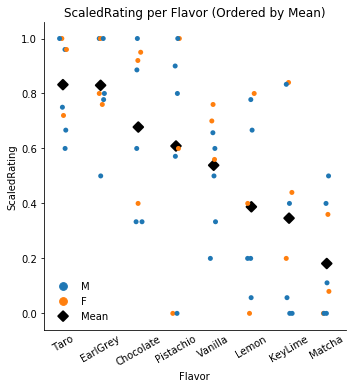

In [278]:
# Questions
# (1) Does the order in which things were tried diminish the effect?
# TBD
# my thought is that controls are needed e.g. alternative universes where different orderings were tried
# or where all flavors are the same rating but tried in different orders

# (2) Couple-independent, which flavor was the best?

# obtain descending list of flavor ratings
df_mean = df_scaled.mean()
df_sorted = df_mean.sort_values(ascending=False)
sorted_flavors = list(df_sorted.index.values)

# create catplot with gender hues and in descending order
g = sns.catplot(data=df_long, x="Flavor", y="ScaledRating", hue='Gender',order=sorted_flavors, legend=False)
ax = g.ax

# add means
sns.pointplot(data=df_long, x="Flavor", y="ScaledRating", estimator=np.mean, order=sorted_flavors,
              join=False, ci=None, markers=['D'], color='black', size=10, zorder=3, ax=ax)

# formatting
# voodoo magic thanks to https://stackoverflow.com/questions/70778988/how-add-average-values-to-a-categorical-plot-in-python
ax.tick_params(axis='x', rotation=0, length=0)
sns.despine(right=True, top=True)
g.set_xticklabels(rotation=30)
ax.collections[-1].set_label('Mean')
ax.legend(frameon=False, loc="lower left")

# add title and save
g.set(title='ScaledRating per Flavor (Ordered by Mean)')
plt.savefig(path + 'outputs/Figure1.pdf', dpi=300, bbox_inches='tight')


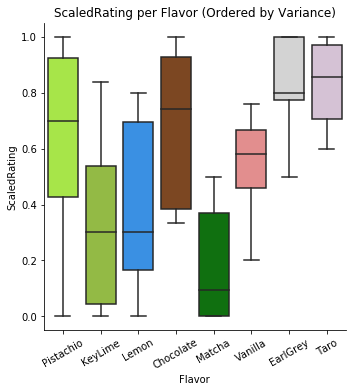

In [279]:
# (3) Which flavors were the most and least controversial?

# obtain descending list of flavor ratings
df_var = df_scaled.var()
df_sorted = df_var.sort_values(ascending=False)
sorted_flavors = list(df_sorted.index.values)

# a future commit might involve recoloring the box plots to match the flavor
# an attempt was made here
# https://sites.google.com/view/paztronomer/blog/basic/python-colors
flavor_to_color = {
    'Pistachio': 'greenyellow',
    'KeyLime': 'yellowgreen',
    'Lemon': 'dodgerblue', # made to blue b/c blueberry; originally 'lemonhchiffon', which I had no idea that was a color
    'Chocolate': 'saddlebrown',
    'Matcha': 'green',
    'Vanilla': 'lightcoral', # originally 'ivory', but made to red b/c has strawberry
    'EarlGrey': 'lightgray', 
    'Taro': 'thistle'
}

# create catplot with gender hues and in descending order
g = sns.catplot(data=df_long_indiv, x="Flavor", y="ScaledRating",kind='box',order=sorted_flavors, palette=flavor_to_color, legend=False)

# formatting
ax.tick_params(axis='x', rotation=0, length=0)
sns.despine(right=True, top=True)
g.set_xticklabels(rotation=30)

# add title and save
g.set(title='ScaledRating per Flavor (Ordered by Variance)')
plt.savefig(path + 'outputs/S1.pdf', dpi=300, bbox_inches='tight')



In [280]:
# create table 1 of mean and var of ratings
table1 = pd.DataFrame({
    'Flavor': df_mean.index,
    'Mean ScaledRating': np.array(df_mean),
    'Var ScaledRating': np.array(df_var)
}).set_index('Flavor')
table1.to_csv(path + '/outputs/Table1.csv',index=True)
table1

,Mean ScaledRating,Var ScaledRating
Flavor,,
Taro,0.832083,0.027092
Matcha,0.181389,0.042161
KeyLime,0.346310,0.119638
EarlGrey,0.829722,0.029290
Vanilla,0.538810,0.035946
Chocolate,0.677798,0.085762
Lemon,0.387698,0.104310
Pistachio,0.608929,0.167168


In [281]:
# (4) Which couples were the most concordant?
# to quantify intra-couple concordance, we plot the differences between couples
# here we do absolute difference so that directionality is irrelevant
# we also arbitrarily choose a linear/L1 distance so that greater differences are not penalized as would be in a squared error model

couple_to_diffs = {}
for c in set(Couple_ID):
    # subset on couple
    df_couple = df_scaled[df_scaled['Couple_ID'] == c]

    # drop non-diff cols
    df_couple = df_couple.drop(['Name','Couple_ID','Gender'], axis=1)
    
    # performs a pairwise row_diff with respect to the first row, so we take the second since the first is NaN
    df_diff = df_couple.diff().iloc[1,:]
    
    # take absolute value since ordering is not relevant/considered in analysis for equity
    couple_to_diffs[c] = np.abs(df_diff)
    
# create df from diffs
df_diff = pd.DataFrame.from_dict(couple_to_diffs, orient='index')
df_diff

,Taro,Matcha,KeyLime,EarlGrey,Vanilla,Chocolate,Lemon,Pistachio
ME,0.240000,0.360000,0.040000,0.000000,0.160000,0.200000,0.600000,0.800000
AK,0.400000,0.400000,0.200000,0.300000,0.500000,0.050000,0.200000,0.300000
JG,0.040000,0.080000,0.782857,0.040000,0.097143,0.034286,0.057143,0.428571
RK,0.083333,0.388889,0.833333,0.222222,0.166667,0.000000,0.111111,1.000000


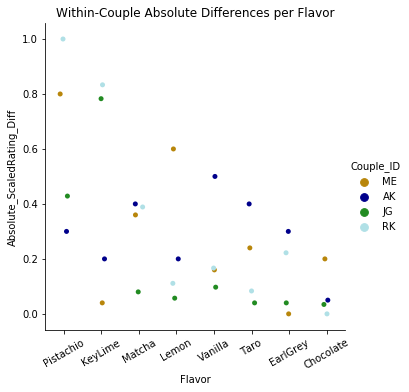

In [282]:
# get sorted flavors in terms of increasing concordance
df_mean = df_diff.mean()
df_sorted = df_mean.sort_values(ascending=False)
sorted_flavors = list(df_sorted.index.values)

# melt to create long form
df = df_diff.reset_index()
df = df.rename(columns={ df.columns[0]: 'Couple_ID' })
df_long_couple = pd.melt(df, id_vars=['Couple_ID'], var_name="Flavor", value_name='ScaledRating')

# choosing this was interesting 
couple_to_color = {
        'ME': 'darkgoldenrod', # because earthbending
        'AK': 'darkblue', # because Allen has 5+ pairs of the same dark jeans
        'JG': 'forestgreen', # because vegetables
        'RK': 'powderblue' # because Lutheran steam engine
}

# plot
g = sns.catplot(data=df_long_couple, x='Flavor', y='ScaledRating', order=sorted_flavors, hue='Couple_ID',palette=couple_to_color)

# formatting
ax.tick_params(axis='x', rotation=0, length=0)
sns.despine(right=True, top=True)
g.set_xticklabels(rotation=30)

# add title
g.set_axis_labels('Flavor', 'Absolute_ScaledRating_Diff')
g.set(title='Within-Couple Absolute Differences per Flavor')
plt.savefig(path + 'outputs/S2.pdf', dpi=300, bbox_inches='tight')

# this implies that in one couple, one person felt that pistachio was the BEST and the other person felt it was the WORST
# chocolate was the least controversial flavor in terms of couple discordance, pistachio was the most


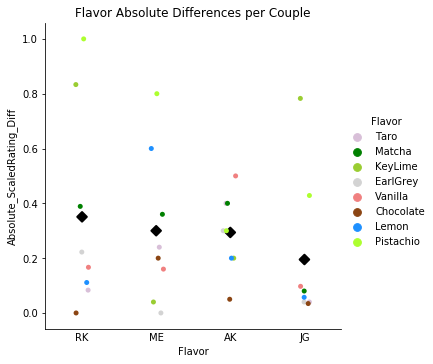

In [283]:
# plot the couple differences
df_mean = df_diff.T.mean()

# melt to create long form
df = df_diff.reset_index()
df = df.rename(columns={ df.columns[0]: 'Couple_ID' })
df_long_couple = pd.melt(df, id_vars=['Couple_ID'], var_name="Flavor", value_name='ScaledRating')

# get sorted couples in terms of increasing concordance
df_sorted = df_mean.sort_values(ascending=False)
sorted_couples = list(df_sorted.index.values)

# plot
g = sns.catplot(data=df_long_couple, x='Couple_ID', y='ScaledRating', order=sorted_couples, hue='Flavor',palette=flavor_to_color)
ax = g.ax

# add means
sns.pointplot(data=df_long_couple, x="Couple_ID", y="ScaledRating", estimator=np.mean, order=sorted_couples,
              join=False, ci=None, markers=['D'], color='black', size=10, zorder=3, ax=ax)

# formatting
ax.tick_params(axis='x', rotation=0, length=0)

# add title
g.set_axis_labels('Flavor', 'Absolute_ScaledRating_Diff')
g.set(title='Flavor Absolute Differences per Couple')
plt.savefig(path + 'outputs/Figure2.pdf', dpi=300, bbox_inches='tight')

# interestingly, the couple with the least spread in their differences was not the lowest average difference
# also it's perhaps good that Richard and Kevin aren't dating alas :') 